In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import random
from collections import Counter
import matplotlib.pyplot as plt
from openai import OpenAI
from tqdm import tqdm
from collections import defaultdict
from scipy import stats
import json
import pandas as pd
import numpy as np

In [12]:
from dotenv import load_dotenv

load_dotenv()

True

In [13]:
import sys
from pathlib import Path
import os

project_root = os.getenv('PROJECT_ROOT')
sys.path.append(str(project_root))
print(project_root)
print(os.getcwd())

/Users/ivang/PycharmProjects/pythonProject/
/Users/ivang/PycharmProjects/pythonProject/notebooks


In [14]:
def construct_stage_1(document: str, tags: list):
    return f"""Intruder Detection
Please read the following document carefully:
"{document}"

Now, examine the list of tags below. One of these tags is an 'intruder' that doesn't belong. Please identify this intruder tag:
{', '.join(tags)}
---
Give your answer in JSON format {{"intruder": "..."}}
"""

In [15]:
def construct_stage_2(document: str, true_tags: list):
    return f"""Tag Quality Assessment
Now that you've identified the intruder, here are the predicted tags for this document:
{', '.join(true_tags)}
And here is the document again:
"{document}"
Please rate each tag on its relevance using the 1-5 scales.

Relevance measures how well each tag represents the main themes of the document.

1 - Not relevant at all 2 - Slightly relevant 3 - Moderately relevant 4 - Very relevant 5 - Extremely relevant
---
Please rate each tag on its generality using the 1-5 scales.

Generality measures how general or specific the tag is to this particular document.

1 - Not general at all, specific to this document 2 - Slightly general 3 - Moderately general 4 - Very general 5 - Highly general, could apply to many documents Not Applicable
---
Please rate the coverage using the 1-5 scales.

Coverage measures how well the set of tags covers the range of themes within the document.

1 - Poor coverage, misses major themes, 2 - Limited coverage, 3 - Moderate coverage, 4 - Good coverage, 5 - Excellent coverage, captures all major themes
---
If you selected any rating other than 5: Excellent coverage, please suggest additional tags that would improve the coverage of the document's themes.
---
Give your answer in JSON format {{"relevance": {{"keyword": relevance_score}}, "generality": {{"keyword": generality_score}}, "coverage": coverage_score, "additional_tags": [...]}}, where "keyword" is a string corresponding to the specific keyword, and score is the score you'd give (number)."""

In [16]:
def append_to_json(file_path, new_data):
    """Append new data to a JSON array stored in a file."""
    if os.path.exists(file_path):
        with open(file_path, 'r+') as file:
            # Load existing data
            try:
                data = json.load(file)
            except json.JSONDecodeError:
                data = []
            # Append new data
            data.append(new_data)
            # Move the file pointer to the beginning
            file.seek(0)
            # Write the updated data
            json.dump(data, file, indent=2)
            # Truncate the file to the current size
            file.truncate()
    else:
        with open(file_path, 'w') as file:
            # Write new data in a list
            json.dump([new_data], file, indent=2)

In [17]:
# from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type 

# client = OpenAI()

# output_file = 'gpt_evaluation_results.json'

# @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
# def make_openai_request(messages, model="gpt-4o-mini"):
#     return client.chat.completions.create(
#         model=model,
#         response_format={"type": "json_object"},
#         messages=messages
#     )

# def process_entry(entry):
#     document = entry['sequence'].split("Keywords:")[0]
#     true_tags = entry['labels'] + entry['overarching_labels'] + entry['keywords_labels']
#     lowest_confidence_tag = entry['lowest_confidence_label']
#     tags = true_tags + [lowest_confidence_tag]
#     random.shuffle(tags)
    
#     stage_1 = construct_stage_1(document, tags)
#     stage_2 = construct_stage_2(document, true_tags)
    
#     messages = [
#         {"role": "system", "content": "You are a helpful assistant designed to output JSON."},
#         {"role": "user", "content": stage_1}
#     ]
    
#     response_1 = make_openai_request(messages)
    
#     result_1 = json.loads(response_1.choices[0].message.content)
    
#     messages.append({"role": "assistant", "content": response_1.choices[0].message.content})
#     messages.append({"role": "user", "content": stage_2})
    
#     response_2 = make_openai_request(messages)
    
#     result_2 = json.loads(response_2.choices[0].message.content)
    
#     return {
#         "document": document,
#         "true_tags": true_tags,
#         "lowest_confidence_tag": lowest_confidence_tag,
#         "stage_1_result": result_1,
#         "stage_2_result": result_2
#     }
# for entry in tqdm(human_evaluation_all, desc="Processing entries"):
# for entry in tqdm(not_found_entries, desc="Processing entries"):
#     try:
#         result_data = process_entry(entry)
#         append_to_json(output_file, result_data)
#     except Exception as e:
#         print(f"Error processing entry: {e}")
#         continue

# print(f"Results saved to {output_file}")

In [18]:
# not_found_entries = []
# with open("gpt_evaluation_results.json", "r") as f:
#     gpt_evaluation_results = json.load(f)
#     for entry in human_evaluation_all:
#         found_entry = False
#         for entry2 in gpt_evaluation_results:
#             # if entry2['document'].contains(entry['sequence']):
#             # if contains
#             if entry2['document'] in entry['sequence']:
#                 found_entry = True
#                 break
#         if not found_entry:
#             not_found_entries.append(entry)

# len(not_found_entries)
        

# GPT evaluation results baseline

In [19]:
with open(f"./human_evaluation_baseline_all.json", "r") as f:
    human_evaluation_baseline_all = json.load(f)

In [20]:
# from tenacity import retry, stop_after_attempt, wait_exponential

# client = OpenAI()

# output_file = 'gpt_evaluation_results_baseline.json'

# @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
# def make_openai_request(messages, model="gpt-4o-mini"):
#     return client.chat.completions.create(
#         model=model,
#         response_format={"type": "json_object"},
#         messages=messages
#     )

# def process_entry(entry):
#     document = entry['sequence'].split("Keywords:")[0]
#     true_tags = entry['labels']
#     lowest_confidence_tag = entry['lowest_confidence_label']
#     tags = true_tags + [lowest_confidence_tag]
#     random.shuffle(tags)
    
#     stage_1 = construct_stage_1(document, tags)
#     stage_2 = construct_stage_2(document, true_tags)
#     messages = [
#         {"role": "system", "content": "You are a helpful assistant designed to output JSON."},
#         {"role": "user", "content": stage_1}
#     ]
    
#     response_1 = make_openai_request(messages)
    
#     result_1 = json.loads(response_1.choices[0].message.content)
    
#     messages.append({"role": "assistant", "content": response_1.choices[0].message.content})
#     messages.append({"role": "user", "content": stage_2})
    
#     response_2 = make_openai_request(messages)
    
#     result_2 = json.loads(response_2.choices[0].message.content)
    
#     return {
#         "document": document,
#         "true_tags": true_tags,
#         "lowest_confidence_tag": lowest_confidence_tag,
#         "stage_1_result": result_1,
#         "stage_2_result": result_2
#     }

# for entry in tqdm(human_evaluation_baseline_all, desc="Processing entries"):
#     try:
#         result_data = process_entry(entry)
#         append_to_json(output_file, result_data)
#     except Exception as e:
#         print(f"Error processing entry: {e}")
#         continue

# print(f"Results saved to {output_file}")

# GPT evaluation of human-generated tags

In [21]:
human_generated_tags = [
    {
        "sequence": """League of Legends Solo Queue Ranked Games\n\nContext: League of Legends is a multiplayer online battle arena where two teams, blue and red, face off. There are three lanes, a jungle, and five roles. The goal is to take down the enemy Nexus to win the game.\n\nContent: This dataset contains statistics of ranked games from a Platinum Elo. Each game is unique and can be identified by its gameId, which can be used to fetch more attributes from the Riot API. Each game has features from different time frames, from ten minutes to the end of the game. For example, game one at ten minutes, game one at twelve minutes, game one at fourteen minutes, and so on. In total, there are over two hundred forty thousand game frames. There are fifty-five features collected for the Blue team, including kills, deaths, gold, experience, and level. It is up to the user to do some feature engineering to get more insights.\n\nThe column hasWon is the target value if you are doing classification to predict the game outcome. Otherwise, you can use the gameDuration attribute if you want to predict the game duration. Attributes starting with "is" are boolean categorical values, either zero or one.\n\nFeatures: gameId, gameDuration, hasWon, frame, gold difference, experience difference, champion level difference, is first tower, is first blood, killed fire drake, killed water drake, killed air drake, killed earth drake, killed elder drake, lost fire drake, lost water drake, lost air drake, lost earth drake, lost elder drake, killed Baron Nashor, lost Baron Nashor, killed Rift Herald, lost Rift Herald, destroyed top inhibitor, destroyed mid inhibitor, destroyed bot inhibitor, lost top inhibitor, lost mid inhibitor, lost bot inhibitor, destroyed top Nexus turret, destroyed mid Nexus turret, destroyed bot Nexus turret, lost top Nexus turret, lost mid Nexus turret, lost bot Nexus turret, destroyed top base turret, destroyed mid base turret, destroyed bot base turret, lost top base turret, lost mid base turret, lost bot base turret, destroyed top inner turret, destroyed mid inner turret, destroyed bot inner turret, lost top inner turret, lost mid inner turret, lost bot inner turret, destroyed top outer turret, destroyed mid outer turret, destroyed bot outer turret, lost top outer turret, lost mid outer turret, lost bot outer turret, kills, deaths, assists, wards placed, wards destroyed, wards lost\n\nKeywords: League of Legends, ranked games, solo queue, game statistics, feature engineering, game outcome prediction, game duration prediction.""",
        "labels": [
            "League of Legends",
            "Video Games",
            "Multiplayer",
            "Game Data",
            "Riot API",
            "Battle Arena",
        ],
        "lowest_confidence_label": "Chess",
    },
    {
        "sequence": """FOREX USD/JPY Minute High\n\nTags: finance, forex, forex high, forex minute\n\nSource: Dukascopy Historical Data Feed\n\nData Description\n\nThis dataset contains historical price data of the FOREX USD/JPY from Dukascopy. Each instance, or row, represents one candlestick of one minute. The dataset spans from January first to December thirteenth and does not include weekends, as the FOREX market is not traded on weekends. The timezone of the feature Timestamp is Europe/Amsterdam.\n\nThe class attribute is the direction of the mean of the High Bid and the High Ask of the following minute, relative to the High Bid and High Ask mean of the current minute. This means the class attribute is True when the mean High price is going up in the following minute, and the class attribute is False when the mean High price is going down or stays the same in the following minute.\n\nNote that this is a hypothetical task, meant for scientific purposes only. Realistic trade strategies can only be applied to predictions on Close attributes, which are also available.\n\nAttributes\n\nTimestamp: The time of the current data point in Europe/Amsterdam\nBid Open: The bid price at the start of this time interval\nBid High: The highest bid price during this time interval\nBid Low: The lowest bid price during this time interval\nBid Close: The bid price at the end of this time interval\nBid Volume: The number of times the Bid Price changed within this time interval\nAsk Open: The ask price at the start of this time interval\nAsk High: The highest ask price during this time interval\nAsk Low: The lowest ask price during this time interval\nAsk Close: The ask price at the end of this time interval\nAsk Volume: The number of times the Ask Price changed within this time interval\nClass: Whether the average price will go up during the next interval\n\nKeywords: FOREX, USD/JPY, historical data, candlestick, finance, trading""",
        "labels": [
            "Historical Price Data",
            "Forex",
            "USD/JPY",
            "Currency Pairs",
            "Yearly Data",
            "Finance",
            "Minute High"
        ],
        "lowest_confidence_label": "Species",
    },
    {
        "sequence": """Lung Dataset, a microarray dataset, consists of 203 instances and 5 classes. This dataset is a classification of human lung carcinomas by mRNA expression profiling, which reveals distinct adenocarcinoma subclasses. The dataset is a comprehensive collection of gene expression profiles, providing valuable insights into the molecular mechanisms underlying lung cancer.\n\nThe dataset features a wide range of gene expression profiles, including those related to immune response, cell signaling, and metabolism. These profiles are essential for understanding the complex biology of lung cancer and for identifying potential therapeutic targets.\n\nThe dataset is a valuable resource for researchers and clinicians, providing a comprehensive understanding of lung cancer biology and facilitating the development of personalized treatment strategies.\n\nKeywords: Lung Cancer, Gene Expression, Microarray, mRNA Profiling, Adenocarcinoma Subclasses.""",
        "labels": [
            "Lung Cancer",
            "Cancer",
            "Oncology",
            "mRNA Expression Profiling",
            "Biology",
            "Carcinomas",
            "Gene Expression Profiles"
        ],
        "lowest_confidence_label": "Breast Cancer",
    }
]

In [22]:
# from tenacity import retry, stop_after_attempt, wait_exponential

# client = OpenAI()

# output_file = 'gpt_evaluation_results_human.json'

# @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
# def make_openai_request(messages, model="gpt-4o-mini"):
#     return client.chat.completions.create(
#         model=model,
#         response_format={"type": "json_object"},
#         messages=messages
#     )

# def process_entry(entry):
#     document = entry['sequence']
#     true_tags = entry['labels']
#     lowest_confidence_tag = entry['lowest_confidence_label']
#     tags = true_tags + [lowest_confidence_tag]
#     random.shuffle(tags)
    
#     stage_1 = construct_stage_1(document, tags)
#     stage_2 = construct_stage_2(document, true_tags)
#     messages = [
#         {"role": "system", "content": "You are a helpful assistant designed to output JSON."},
#         {"role": "user", "content": stage_1}
#     ]
    
#     response_1 = make_openai_request(messages)
    
#     result_1 = json.loads(response_1.choices[0].message.content)
    
#     messages.append({"role": "assistant", "content": response_1.choices[0].message.content})
#     messages.append({"role": "user", "content": stage_2})
    
#     response_2 = make_openai_request(messages)
    
#     result_2 = json.loads(response_2.choices[0].message.content)
    
#     return {
#         "document": document,
#         "true_tags": true_tags,
#         "lowest_confidence_tag": lowest_confidence_tag,
#         "stage_1_result": result_1,
#         "stage_2_result": result_2
#     }

# for entry in tqdm(human_generated_tags, desc="Processing entries"):
#     try:
#         result_data = process_entry(entry)
#         append_to_json(output_file, result_data)
#     except Exception as e:
#         print(f"Error processing entry: {e}")
#         continue

# print(f"Results saved to {output_file}")

# Results

Choose which dataset to load (default or baseline)

In [23]:
# These two have the same end format
# dataset_to_use = "gpt_evaluation_results_baseline.json" # based on human_evaluation_baseline_all
dataset_to_use = "gpt_evaluation_results.json" # based on human_evaluation_all
# dataset_to_use = "gpt_evaluation_results_human.json" # based on human_generated_tags

with open(dataset_to_use, 'r') as f:
    results = json.load(f)

In [24]:
# human_evaluation_all and human_evaluation have the same format, but not human_evaluation_baseline_all
human_evaluation_to_use = "human_evaluation_all.json"
# human_evaluation_to_use = "human_evaluation_baseline_all.json" # this one won't work, since it doesn't have labels, overarching_labels, and keywords_labels, so just don't use it
# human_evaluation_to_use = "human_evaluation.json" # contains only the datasets that are/were to be rated by humans (subset of human_evaluation_all)

with open(human_evaluation_to_use, "r") as f:
    human_evaluation = json.load(f)

In [27]:
# leave only those in data that are in human_evaluation
new_data = []
for i in range(len(results)):
    for j in range(len(human_evaluation)):
        if results[i]['document'] in human_evaluation[j]['sequence'] or human_evaluation[j]['sequence'] in results[i]['document']:
            new_data.append(results[i])
            break

results = new_data
results

[{'document': 'League of Legends Solo Queue Ranked Games\n\nContext: League of Legends is a multiplayer online battle arena where two teams, blue and red, face off. There are three lanes, a jungle, and five roles. The goal is to take down the enemy Nexus to win the game.\n\nContent: This dataset contains statistics of ranked games from a Platinum Elo. Each game is unique and can be identified by its gameId, which can be used to fetch more attributes from the Riot API. Each game has features from different time frames, from ten minutes to the end of the game. For example, game one at ten minutes, game one at twelve minutes, game one at fourteen minutes, and so on. In total, there are over two hundred forty thousand game frames. There are fifty-five features collected for the Blue team, including kills, deaths, gold, experience, and level. It is up to the user to do some feature engineering to get more insights.\n\nThe column hasWon is the target value if you are doing classification to 

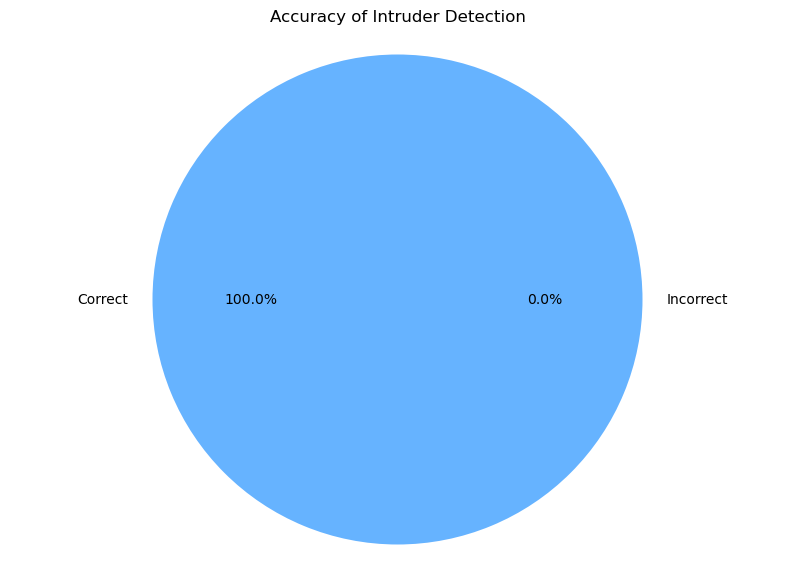

In [28]:
correct_detections = sum(1 for entry in results if entry['stage_1_result']['intruder'] == entry['lowest_confidence_tag'])
total_entries = len(results)
incorrect_detections = total_entries - correct_detections

plt.figure(figsize=(10, 7))
plt.pie([correct_detections, incorrect_detections], 
        labels=['Correct', 'Incorrect'], 
        autopct='%1.1f%%',
        colors=['#66b3ff', '#ff9999'])
plt.title('Accuracy of Intruder Detection')
plt.axis('equal')
plt.show()

In [29]:
# Initialize a dictionary to count misidentifications
misidentifications = defaultdict(int)

# Count misidentifications
for entry in results:
    predicted_intruder = entry['lowest_confidence_tag']
    actual_intruder = entry['stage_1_result']['intruder']
    
    if predicted_intruder != actual_intruder:
        misidentifications[predicted_intruder] += 1

# Sort tags by number of misidentifications
sorted_misidentifications = sorted(misidentifications.items(), key=lambda x: x[1], reverse=True)

# Select top N tags
N = min(20, len(sorted_misidentifications))
top_n_tags = sorted_misidentifications[:N]

# Prepare data for plotting
tags, counts = zip(*top_n_tags)
# Create the bar chart
plt.figure(figsize=(15, 8))
plt.bar(range(N), counts)
plt.title(f'Top {N} Most Frequently Misidentified Tags')
plt.xlabel('Tag')
plt.ylabel('Number of Misidentifications')
plt.xticks(range(N), tags, rotation=90)

# Add value labels on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [30]:
from collections import defaultdict
import numpy as np

# Initialize dictionaries to store counts
total_counts = defaultdict(int)
correct_counts = defaultdict(int)

# Process the data
for entry in results:
    num_true_tags = len(entry['true_tags'])
    total_counts[num_true_tags] += 1
    
    if entry['lowest_confidence_tag'] == entry['stage_1_result']['intruder']:
        correct_counts[num_true_tags] += 1

# Calculate percentages
percentages = {k: (correct_counts[k] / total_counts[k]) * 100 if total_counts[k] > 0 else 0 
               for k in total_counts.keys()}

# Print statistics
print("Number of tags | Occurrences | Percentage of correct identifications")
print("-" * 60)
for num_tags in sorted(total_counts.keys()):
    occurrences = total_counts[num_tags]
    percentage = percentages[num_tags]
    print(f"{num_tags:14d} | {occurrences:11d} | {percentage:6.1f}%")

# Function to calculate correlation for a given range
def calculate_correlation(data, max_tags):
    filtered_data = {k: v for k, v in data.items() if k <= max_tags}
    x = list(filtered_data.keys())
    y = list(filtered_data.values())
    if len(x) > 1:  # Need at least two points for correlation
        return np.corrcoef(x, y)[0, 1]
    else:
        return None

# Calculate correlations for different ranges
ranges = [3, 5, 7, 10, 15, 25, max(percentages.keys())]
correlations = {}

for r in ranges:
    corr = calculate_correlation(percentages, r)
    correlations[r] = corr

# Print correlations
print("\nCorrelations between number of true tags and percentage of correct identifications:")
for r in ranges:
    corr = correlations[r]
    if corr is not None:
        print(f"Up to {r:2d} tags: r = {corr:.3f}")
    else:
        print(f"Up to {r:2d} tags: Insufficient data")

# Calculate overall correlation
x = list(percentages.keys())
y = list(percentages.values())
overall_correlation = np.corrcoef(x, y)[0, 1]

print(f"\nOverall correlation: r = {overall_correlation:.3f}")

Number of tags | Occurrences | Percentage of correct identifications
------------------------------------------------------------
             6 |           1 |  100.0%
             7 |           2 |  100.0%

Correlations between number of true tags and percentage of correct identifications:
Up to  3 tags: Insufficient data
Up to  5 tags: Insufficient data
Up to  7 tags: r = nan
Up to 10 tags: r = nan
Up to 15 tags: r = nan
Up to 25 tags: r = nan
Up to  7 tags: r = nan

Overall correlation: r = nan


/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


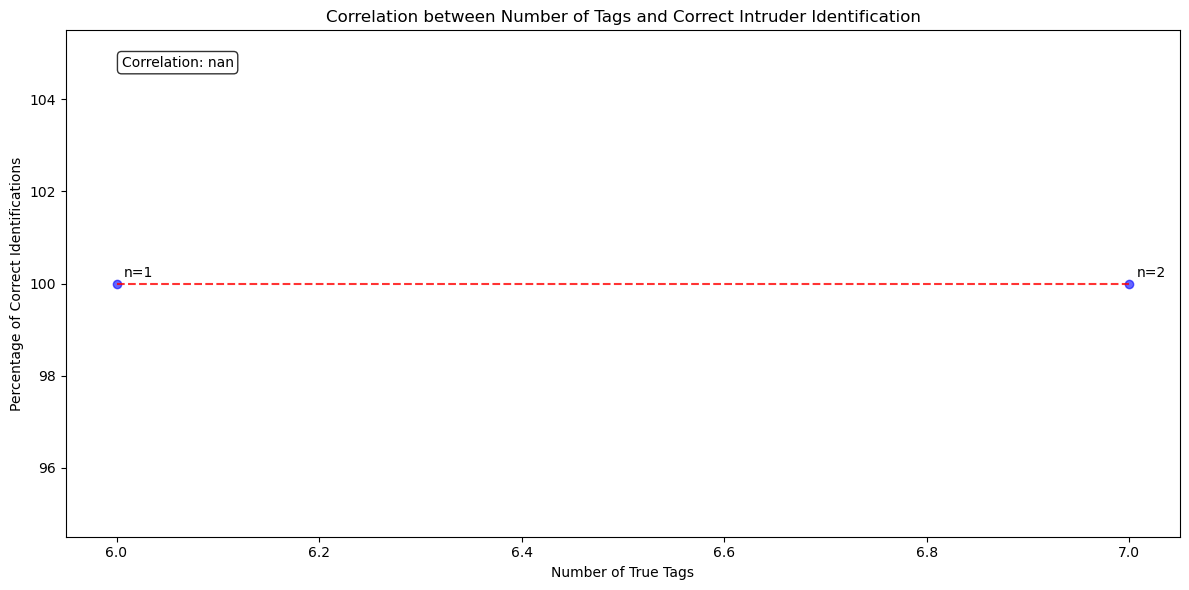

In [31]:
# Initialize dictionaries to store counts
total_counts = defaultdict(int)
correct_counts = defaultdict(int)

# Process the data
for entry in results:
    num_true_tags = len(entry['true_tags'])
    total_counts[num_true_tags] += 1
    
    if entry['lowest_confidence_tag'] == entry['stage_1_result']['intruder']:
        correct_counts[num_true_tags] += 1

# Calculate percentages
percentages = {k: (correct_counts[k] / total_counts[k]) * 100 if total_counts[k] > 0 else 0 
               for k in total_counts.keys()}

# Prepare data for plotting
x = list(percentages.keys())
y = list(percentages.values())

# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='blue', alpha=0.6)

# Add labels and title
plt.xlabel('Number of True Tags')
plt.ylabel('Percentage of Correct Identifications')
plt.title('Correlation between Number of Tags and Correct Intruder Identification')

# Add a trend line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", alpha=0.8)

# Add text box with correlation coefficient
correlation = np.corrcoef(x, y)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add data labels
for i, txt in enumerate(total_counts.values()):
    plt.annotate(f"n={txt}", (x[i], y[i]), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

Correlation between relevance and generality: -0.976
Spearman Correlation between relevance and generality: -1.000
P-value: 0.139
Spearman P-value: 0.000


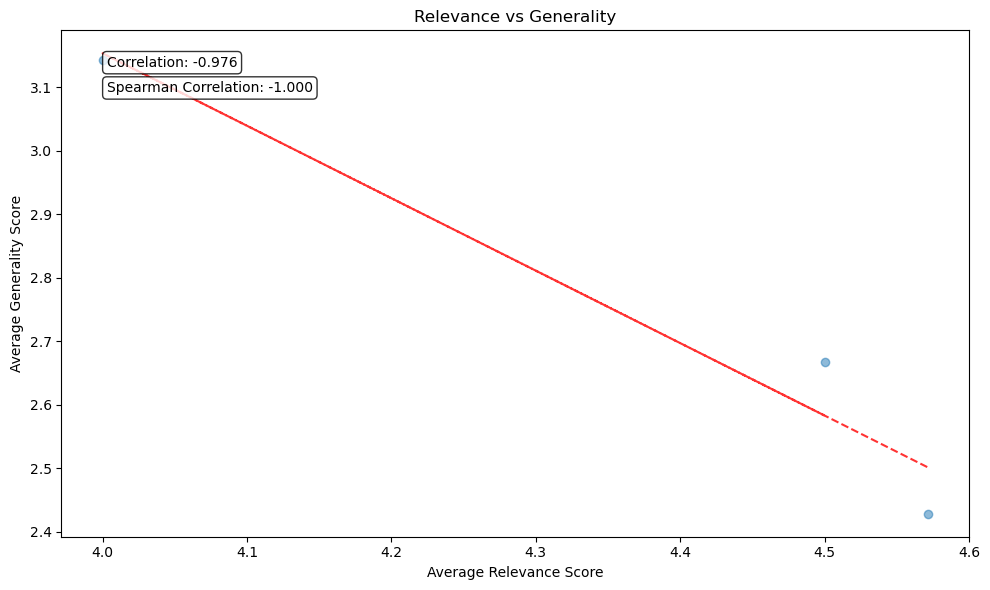

In [32]:
# Lists to store relevance and generality scores
relevance_scores = []
generality_scores = []

# Extract relevance and generality scores
for entry in results:
    if 'stage_2_result' in entry and 'relevance' in entry['stage_2_result'] and 'generality' in entry['stage_2_result']:
        relevance = entry['stage_2_result']['relevance']
        generality = entry['stage_2_result']['generality']
        
        # Calculate average scores for each entry
        avg_relevance = sum(relevance.values()) / len(relevance)
        avg_generality = sum(generality.values()) / len(generality)
        
        relevance_scores.append(avg_relevance)
        generality_scores.append(avg_generality)

# Calculate correlation
correlation, p_value = stats.pearsonr(relevance_scores, generality_scores)

# Calculate spearman correlation
spearman_correlation, spearman_p_value = stats.spearmanr(relevance_scores, generality_scores)

print(f"Correlation between relevance and generality: {correlation:.3f}")
print(f"Spearman Correlation between relevance and generality: {spearman_correlation:.3f}")
print(f"P-value: {p_value:.3f}")
print(f"Spearman P-value: {spearman_p_value:.3f}")

plt.figure(figsize=(10, 6))
plt.scatter(relevance_scores, generality_scores, alpha=0.5)
plt.xlabel('Average Relevance Score')
plt.ylabel('Average Generality Score')
plt.title('Relevance vs Generality')

# Add trend line
z = np.polyfit(relevance_scores, generality_scores, 1)
p = np.poly1d(z)
plt.plot(relevance_scores, p(relevance_scores), "r--", alpha=0.8)

# Add correlation coefficient to plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add spearman correlation coefficient to plot
plt.text(0.05, 0.90, f'Spearman Correlation: {spearman_correlation:.3f}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize data structures
tag_relevance = defaultdict(list)
tag_generality = defaultdict(list)
all_relevance_scores = []
all_generality_scores = []
all_coverage_scores = []

# Process the data
for entry in results:
    if 'stage_2_result' in entry:
        if 'relevance' in entry['stage_2_result']:
            relevance_scores = entry['stage_2_result']['relevance']
            for tag, score in relevance_scores.items():
                tag_relevance[tag].append(score)
                all_relevance_scores.append(score)
        if 'generality' in entry['stage_2_result']:
            generality_scores = entry['stage_2_result']['generality']
            for tag, score in generality_scores.items():
                tag_generality[tag].append(score)
                all_generality_scores.append(score)
        if 'coverage' in entry['stage_2_result']:
            coverage_score = entry['stage_2_result']['coverage']
            all_coverage_scores.append(coverage_score)

# Calculate average scores per tag
avg_relevance_per_tag = {tag: sum(scores) / len(scores) for tag, scores in tag_relevance.items()}
avg_generality_per_tag = {tag: sum(scores) / len(scores) for tag, scores in tag_generality.items()}
avg_coverage = sum(all_coverage_scores) / len(all_coverage_scores)

# Calculate means and standard deviations
relevance_mean = np.mean(all_relevance_scores)
generality_mean = np.mean(all_generality_scores)
relevance_std = np.std(all_relevance_scores)
generality_std = np.std(all_generality_scores)
coverage_mean = np.mean(all_coverage_scores)
coverage_std = np.std(all_coverage_scores)

# Sort tags by average scores
sorted_relevance_tags = sorted(avg_relevance_per_tag.items(), key=lambda x: x[1], reverse=True)
sorted_generality_tags = sorted(avg_generality_per_tag.items(), key=lambda x: x[1], reverse=True)

# Create subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=(
    "Average Relevance Score per Tag", "Average Generality Score per Tag",
    "Overall Distribution of Relevance Scores", "Overall Distribution of Generality Scores",
    "Overall Distribution of Coverage Scores"
))

# Add bar charts for average scores
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_relevance_tags], y=[score for _, score in sorted_relevance_tags], name="Avg Relevance"), row=1, col=1)
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_generality_tags], y=[score for _, score in sorted_generality_tags], name="Avg Generality"), row=1, col=2)

# Add histograms for overall distribution of scores
fig.add_trace(go.Histogram(x=all_relevance_scores, nbinsx=20, name="Relevance Distribution"), row=2, col=1)
fig.add_trace(go.Histogram(x=all_generality_scores, nbinsx=20, name="Generality Distribution"), row=2, col=2)
fig.add_trace(go.Histogram(x=all_coverage_scores, nbinsx=5, name="Coverage Distribution"), row=3, col=1)

# Add vertical lines for mean and standard deviations on relevance histogram
fig.add_vline(x=relevance_mean, line_dash="solid", line_color="red", row=2, col=1)
fig.add_vline(x=relevance_mean - relevance_std, line_dash="dash", line_color="green", row=2, col=1)
fig.add_vline(x=relevance_mean + relevance_std, line_dash="dash", line_color="green", row=2, col=1)

# Add vertical lines for mean and standard deviations on generality histogram
fig.add_vline(x=generality_mean, line_dash="solid", line_color="red", row=2, col=2)
fig.add_vline(x=generality_mean - generality_std, line_dash="dash", line_color="green", row=2, col=2)
fig.add_vline(x=generality_mean + generality_std, line_dash="dash", line_color="green", row=2, col=2)

# Add vertical line for average coverage
fig.add_vline(x=avg_coverage, line_dash="solid", line_color="red", row=3, col=1)
fig.add_vline(x=coverage_mean, line_dash="solid", line_color="red", row=3, col=1)
fig.add_vline(x=coverage_mean - coverage_std, line_dash="dash", line_color="green", row=3, col=1)
fig.add_vline(x=coverage_mean + coverage_std, line_dash="dash", line_color="green", row=3, col=1)

# Update layout
fig.update_layout(height=1200, title_text="Tag Relevance and Generality Analysis", showlegend=False)
fig.update_xaxes(title_text="Tag", row=1, col=1)
fig.update_xaxes(title_text="Tag", row=1, col=2)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=1, col=1)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=1, col=2)
fig.update_xaxes(title_text="Score", row=2, col=1)
fig.update_xaxes(title_text="Score", row=2, col=2)
fig.update_yaxes(title_text="Count", row=2, col=1)
fig.update_yaxes(title_text="Count", row=2, col=2)

# Add annotations for overall averages and standard deviations
fig.add_annotation(text=f"Mean: {relevance_mean:.2f}<br>Std Dev: {relevance_std:.2f}", xref="x3", yref="paper", x=0.5, y=1.05, showarrow=False)
fig.add_annotation(text=f"Mean: {generality_mean:.2f}<br>Std Dev: {generality_std:.2f}", xref="x4", yref="paper", x=0.5, y=1.05, showarrow=False)

# Add legend for the vertical lines
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='red', dash='solid'), name='Mean'), row=2, col=1)
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='green', dash='dash'), name='±1 Std Dev'), row=2, col=1)

# Show the plot
fig.show()

print(f"\nOverall Average Relevance Score: {relevance_mean:.2f}")
print(f"Overall Average Generality Score: {generality_mean:.2f}")
print(f"Relevance Standard Deviation: {relevance_std:.2f}")
print(f"Generality Standard Deviation: {generality_std:.2f}")


Overall Average Relevance Score: 4.35
Overall Average Generality Score: 2.75
Relevance Standard Deviation: 0.79
Generality Standard Deviation: 0.77


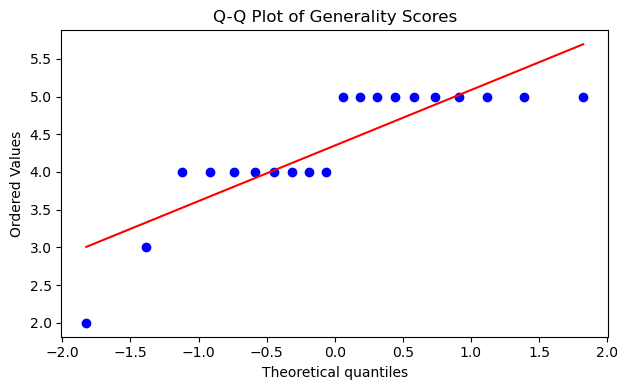

In [35]:
plt.figure(figsize=(12, 4))

# Q-Q Plot
plt.subplot(122)
stats.probplot(all_relevance_scores, dist="norm", plot=plt)
plt.title('Q-Q Plot of Generality Scores')

plt.tight_layout()
plt.show()

In [34]:
# Statistical Tests
# Shapiro-Wilk Test
shapiro_test = stats.shapiro(all_relevance_scores)
print(f"Shapiro-Wilk Test - Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")

# Anderson-Darling Test
anderson_test = stats.anderson(all_relevance_scores, dist='norm')
print(f"Anderson-Darling Test - Statistic: {anderson_test.statistic:.4f}")
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    print(f'  {sl}%: {cv:.3f}')

# Skewness and Kurtosis
skewness = stats.skew(all_relevance_scores)
se_skewness = np.sqrt(6/len(results))
z_skewness = skewness / se_skewness
kurtosis = stats.kurtosis(all_relevance_scores)
print(f"Skewness: {skewness:.4f}")
print(f"Skewness z-score: {z_skewness:.2f}")
print(f"Kurtosis: {kurtosis:.4f}")

# Calculate mean and standard deviation, and mode and median
mean = np.mean(all_relevance_scores)
std_dev = np.std(all_relevance_scores)
mode = stats.mode(all_relevance_scores)
median = np.median(all_relevance_scores)
print(f"Mean: {mean:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Mode: {mode.mode}")
print(f"Median: {median}")

# 4. Check for discrete vs continuous distribution
unique_values = np.unique(all_relevance_scores)
print(f"Number of unique values: {len(unique_values)}")
print(f"Unique values: {unique_values}")

Shapiro-Wilk Test - Statistic: 0.7456, p-value: 0.0001
Anderson-Darling Test - Statistic: 2.0073
  15.0%: 0.506
  10.0%: 0.577
  5.0%: 0.692
  2.5%: 0.807
  1.0%: 0.960
Skewness: -1.3112
Skewness z-score: -0.93
Kurtosis: 1.5364
Mean: 4.3500
Standard Deviation: 0.7921
Mode: 5
Median: 4.5
Number of unique values: 4
Unique values: [2 3 4 5]


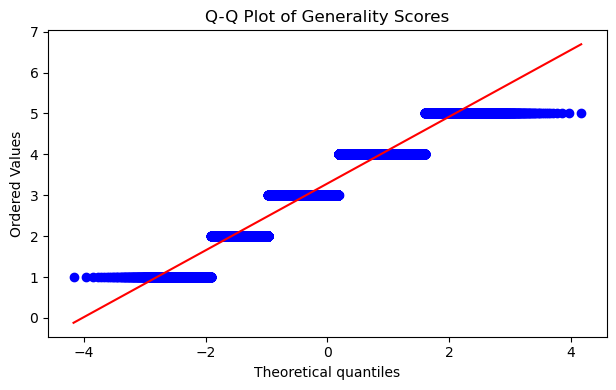

In [ ]:
plt.figure(figsize=(12, 4))

# Q-Q Plot
plt.subplot(122)
stats.probplot(all_generality_scores, dist="norm", plot=plt)
plt.title('Q-Q Plot of Generality Scores')

plt.tight_layout()
plt.show()

In [ ]:
# Statistical Tests
# Shapiro-Wilk Test
shapiro_test = stats.shapiro(all_generality_scores)
print(f"Shapiro-Wilk Test - Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")

# Anderson-Darling Test
anderson_test = stats.anderson(all_generality_scores, dist='norm')
print(f"Anderson-Darling Test - Statistic: {anderson_test.statistic:.4f}")
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    print(f'  {sl}%: {cv:.3f}')

# Skewness and Kurtosis
skewness = stats.skew(all_generality_scores)
se_skewness = np.sqrt(6/len(results))
z_skewness = skewness / se_skewness
kurtosis = stats.kurtosis(all_generality_scores)
print(f"Skewness: {skewness:.4f}")
print(f"Skewness z-score: {z_skewness:.2f}")
print(f"Kurtosis: {kurtosis:.4f}")

# Calculate mean and standard deviation, and mode and median
mean = np.mean(all_generality_scores)
std_dev = np.std(all_generality_scores)
mode = stats.mode(all_generality_scores)
median = np.median(all_generality_scores)
print(f"Mean: {mean:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Mode: {mode.mode}")
print(f"Median: {median}")

# 4. Check for discrete vs continuous distribution
unique_values = np.unique(all_generality_scores)
print(f"Number of unique values: {len(unique_values)}")
print(f"Unique values: {unique_values}")

Shapiro-Wilk Test - Statistic: 0.8786, p-value: 0.0000
Anderson-Darling Test - Statistic: 2641.2348
  15.0%: 0.576
  10.0%: 0.656
  5.0%: 0.787
  2.5%: 0.918
  1.0%: 1.092
Skewness: -0.3544
Skewness z-score: -10.41
Kurtosis: -0.0169
Mean: 3.2869
Standard Deviation: 0.8705
Mode: 3
Median: 3.0
Number of unique values: 5
Unique values: [1 2 3 4 5]


/var/folders/cl/69z7wmcn5xx7cb7wc_xvd8fw0000gn/T/ipykernel_4501/1501710613.py:3: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45916.



Only for the non-baseline datasets

In [36]:
relevance_list = []
scores_list = []
relevance_list_labels = []
scores_list_labels = []
relevance_list_overarching_labels = []
scores_list_overarching_labels = []
relevance_list_keywords = []
scores_list_keywords = []

for result1 in results:
    result2 = [result2 for result2 in human_evaluation if result1['document'] in result2['sequence']][0]
    relevance_list_result1 = list(zip(result1['stage_2_result']['relevance'].keys(), result1['stage_2_result']['relevance'].values()))
    scores_list_result2 = list(zip(result2['labels'] + result2['overarching_labels'] + result2['keywords_labels'], result2['scores'] + result2['overarching_scores'] + result2['keywords_scores']))
    for tuple1 in relevance_list_result1:
        label1 = tuple1[0]
        for tuple2 in scores_list_result2:
            label2 = tuple2[0]
            if label1 == label2:
                relevance = tuple1[1]
                scores = tuple2[1]
                relevance_list.append(relevance)
                scores_list.append(scores)
                if label1 in result2['labels']:
                    relevance_list_labels.append(relevance)
                    scores_list_labels.append(scores)
                elif label1 in result2['overarching_labels']:
                    relevance_list_overarching_labels.append(relevance)
                    scores_list_overarching_labels.append(scores)
                elif label1 in result2['keywords_labels']:
                    relevance_list_keywords.append(relevance)
                    scores_list_keywords.append(scores)
pearson_correlation, pearson_p_value = stats.pearsonr(relevance_list, scores_list)
spearman_correlation, spearman_p_value = stats.spearmanr(relevance_list, scores_list)
                    
pearson_correlation_labels, pearson_p_value_labels = stats.pearsonr(relevance_list_labels, scores_list_labels)
spearman_correlation_labels, spearman_p_value_labels = stats.spearmanr(relevance_list_labels, scores_list_labels)

pearson_correlation_overarching_labels, pearson_p_value_overarching_labels = stats.pearsonr(relevance_list_overarching_labels, scores_list_overarching_labels)
spearman_correlation_overarching_labels, spearman_p_value_overarching_labels = stats.spearmanr(relevance_list_overarching_labels, scores_list_overarching_labels)

pearson_correlation_keywords, pearson_p_value_keywords = stats.pearsonr(relevance_list_keywords, scores_list_keywords)
spearman_correlation_keywords, spearman_p_value_keywords = stats.spearmanr(relevance_list_keywords, scores_list_keywords)

print(f"Pearson Correlation between relevance and scores: {pearson_correlation:.3f}, P-value: {pearson_p_value:.3f}")
print(f"Spearman Correlation between relevance and scores: {spearman_correlation:.3f}, P-value: {spearman_p_value:.3f}")

print(f"Pearson Correlation between relevance and scores for labels: {pearson_correlation_labels:.3f}, P-value: {pearson_p_value_labels:.3f}")
print(f"Spearman Correlation between relevance and scores for labels: {spearman_correlation_labels:.3f}, P-value: {spearman_p_value_labels:.3f}")

print(f"Pearson Correlation between relevance and scores for overarching labels: {pearson_correlation_overarching_labels:.3f}, P-value: {pearson_p_value_overarching_labels:.3f}")
print(f"Spearman Correlation between relevance and scores for overarching labels: {spearman_correlation_overarching_labels:.3f}, P-value: {spearman_p_value_overarching_labels:.3f}")

print(f"Pearson Correlation between relevance and scores for keywords: {pearson_correlation_keywords:.3f}, P-value: {pearson_p_value_keywords:.3f}")
print(f"Spearman Correlation between relevance and scores for keywords: {spearman_correlation_keywords:.3f}, P-value: {spearman_p_value_keywords:.3f}")

ValueError: x and y must have length at least 2.

In [37]:
# Initialize data structures
tag_relevance = defaultdict(list)
tag_generality = defaultdict(list)
all_relevance_scores = []
all_generality_scores = []

overarching_tag_relevance = defaultdict(list)
overarching_tag_generality = defaultdict(list)
all_overarching_relevance_scores = []
all_overarching_generality_scores = []

keywords_tag_relevance = defaultdict(list)
keywords_tag_generality = defaultdict(list)
all_keywords_relevance_scores = []
all_keywords_generality_scores = []

# Process the data
for result1 in results:
    result2 = [result2 for result2 in human_evaluation if result1['document'] in result2['sequence']][0]
    relevance_list_result1 = list(zip(result1['stage_2_result']['relevance'].keys(), result1['stage_2_result']['relevance'].values()))
    generality_list_result1 = list(zip(result1['stage_2_result']['generality'].keys(), result1['stage_2_result']['generality'].values()))
    scores_list_result2 = list(zip(result2['labels'] + result2['overarching_labels'] + result2['keywords_labels'], result2['scores'] + result2['overarching_scores'] + result2['keywords_scores']))
    for i, tuple1 in enumerate(relevance_list_result1):
        label1 = tuple1[0]
        generality = generality_list_result1[i][1]
        for tuple2 in scores_list_result2:
            label2 = tuple2[0]
            if label1 == label2:
                relevance = tuple1[1]
                scores = tuple2[1]
                if label1 in result2['labels']:
                    tag_relevance[label1].append(relevance)
                    tag_generality[label1].append(generality)
                    all_relevance_scores.append(relevance)
                    all_generality_scores.append(generality)
                elif label1 in result2['overarching_labels']:
                    overarching_tag_relevance[label1].append(relevance)
                    overarching_tag_generality[label1].append(generality)
                    all_overarching_relevance_scores.append(relevance)
                    all_overarching_generality_scores.append(generality)
                elif label1 in result2['keywords_labels']:
                    keywords_tag_relevance[label1].append(relevance)
                    keywords_tag_generality[label1].append(generality)
                    all_keywords_relevance_scores.append(relevance)
                    all_keywords_generality_scores.append(generality)
        
# Calculate average scores per tag
avg_relevance_per_tag = {tag: sum(scores) / len(scores) for tag, scores in tag_relevance.items()}
avg_generality_per_tag = {tag: sum(scores) / len(scores) for tag, scores in tag_generality.items()}
avg_overarching_relevance_per_tag = {tag: sum(scores) / len(scores) for tag, scores in overarching_tag_relevance.items()}
avg_overarching_generality_per_tag = {tag: sum(scores) / len(scores) for tag, scores in overarching_tag_generality.items()}
avg_keywords_relevance_per_tag = {tag: sum(scores) / len(scores) for tag, scores in keywords_tag_relevance.items()}
avg_keywords_generality_per_tag = {tag: sum(scores) / len(scores) for tag, scores in keywords_tag_generality.items()}

# Calculate means and standard deviations
relevance_mean = np.mean(all_relevance_scores)
generality_mean = np.mean(all_generality_scores)
relevance_std = np.std(all_relevance_scores)
generality_std = np.std(all_generality_scores)
overarching_relevance_mean = np.mean(all_overarching_relevance_scores)
overarching_generality_mean = np.mean(all_overarching_generality_scores)
overarching_relevance_std = np.std(all_overarching_relevance_scores)
overarching_generality_std = np.std(all_overarching_generality_scores)
keywords_relevance_mean = np.mean(all_keywords_relevance_scores)
keywords_generality_mean = np.mean(all_keywords_generality_scores)
keywords_relevance_std = np.std(all_keywords_relevance_scores)
keywords_generality_std = np.std(all_keywords_generality_scores)

# Sort tags by average scores
sorted_relevance_tags = sorted(avg_relevance_per_tag.items(), key=lambda x: x[1], reverse=True)
sorted_generality_tags = sorted(avg_generality_per_tag.items(), key=lambda x: x[1], reverse=True)
sorted_overarching_relevance_tags = sorted(avg_overarching_relevance_per_tag.items(), key=lambda x: x[1], reverse=True)
sorted_overarching_generality_tags = sorted(avg_overarching_generality_per_tag.items(), key=lambda x: x[1], reverse=True)
sorted_keywords_relevance_tags = sorted(avg_keywords_relevance_per_tag.items(), key=lambda x: x[1], reverse=True)
sorted_keywords_generality_tags = sorted(avg_keywords_generality_per_tag.items(), key=lambda x: x[1], reverse=True)

# Create subplots
fig = make_subplots(rows=6, cols=2, subplot_titles=(
    "Average Relevance Score per Tag (Labels)", "Average Generality Score per Tag (Labels)",
    "Average Relevance Score per Tag (Overarching Labels)", "Average Generality Score per Tag (Overarching Labels)",
    "Average Relevance Score per Tag (Keywords)", "Average Generality Score per Tag (Keywords)",
    "Overall Distribution of Relevance Scores (Labels)", "Overall Distribution of Generality Scores (Labels)",
    "Overall Distribution of Relevance Scores (Overarching Labels)", "Overall Distribution of Generality Scores (Overarching Labels)",
    "Overall Distribution of Relevance Scores (Keywords)", "Overall Distribution of Generality Scores (Keywords)"
))

# Add bar charts for average scores
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_relevance_tags], y=[score for _, score in sorted_relevance_tags], name="Avg Relevance"), row=1, col=1)
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_generality_tags], y=[score for _, score in sorted_generality_tags], name="Avg Generality"), row=1, col=2)
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_overarching_relevance_tags], y=[score for _, score in sorted_overarching_relevance_tags], name="Avg Relevance"), row=2, col=1)
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_overarching_generality_tags], y=[score for _, score in sorted_overarching_generality_tags], name="Avg Generality"), row=2, col=2)
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_keywords_relevance_tags], y=[score for _, score in sorted_keywords_relevance_tags], name="Avg Relevance"), row=3, col=1)
fig.add_trace(go.Bar(x=[tag for tag, _ in sorted_keywords_generality_tags], y=[score for _, score in sorted_keywords_generality_tags], name="Avg Generality"), row=3, col=2)

# Add histograms for overall distribution of scores
fig.add_trace(go.Histogram(x=all_relevance_scores, nbinsx=20, name="Relevance Distribution"), row=4, col=1)
fig.add_trace(go.Histogram(x=all_generality_scores, nbinsx=20, name="Generality Distribution"), row=4, col=2)
fig.add_trace(go.Histogram(x=all_overarching_relevance_scores, nbinsx=20, name="Relevance Distribution"), row=5, col=1)
fig.add_trace(go.Histogram(x=all_overarching_generality_scores, nbinsx=20, name="Generality Distribution"), row=5, col=2)
fig.add_trace(go.Histogram(x=all_keywords_relevance_scores, nbinsx=20, name="Relevance Distribution"), row=6, col=1)
fig.add_trace(go.Histogram(x=all_keywords_generality_scores, nbinsx=20, name="Generality Distribution"), row=6, col=2)

# Add vertical lines for mean and standard deviations on relevance histogram
fig.add_vline(x=relevance_mean, line_dash="solid", line_color="red", row=4, col=1)
fig.add_vline(x=relevance_mean - relevance_std, line_dash="dash", line_color="green", row=4, col=1)
fig.add_vline(x=relevance_mean + relevance_std, line_dash="dash", line_color="green", row=4, col=1)
fig.add_vline(x=overarching_relevance_mean, line_dash="solid", line_color="red", row=5, col=1)
fig.add_vline(x=overarching_relevance_mean - overarching_relevance_std, line_dash="dash", line_color="green", row=5, col=1)
fig.add_vline(x=overarching_relevance_mean + overarching_relevance_std, line_dash="dash", line_color="green", row=5, col=1)
fig.add_vline(x=keywords_relevance_mean, line_dash="solid", line_color="red", row=6, col=1)
fig.add_vline(x=keywords_relevance_mean - keywords_relevance_std, line_dash="dash", line_color="green", row=6, col=1)
fig.add_vline(x=keywords_relevance_mean + keywords_relevance_std, line_dash="dash", line_color="green", row=6, col=1)

# Add vertical lines for mean and standard deviations on generality histogram
fig.add_vline(x=generality_mean, line_dash="solid", line_color="red", row=4, col=2)
fig.add_vline(x=generality_mean - generality_std, line_dash="dash", line_color="green", row=4, col=2)
fig.add_vline(x=generality_mean + generality_std, line_dash="dash", line_color="green", row=4, col=2)
fig.add_vline(x=overarching_generality_mean, line_dash="solid", line_color="red", row=5, col=2)
fig.add_vline(x=overarching_generality_mean - overarching_generality_std, line_dash="dash", line_color="green", row=5, col=2)
fig.add_vline(x=overarching_generality_mean + overarching_generality_std, line_dash="dash", line_color="green", row=5, col=2)
fig.add_vline(x=keywords_generality_mean, line_dash="solid", line_color="red", row=6, col=2)
fig.add_vline(x=keywords_generality_mean - keywords_generality_std, line_dash="dash", line_color="green", row=6, col=2)
fig.add_vline(x=keywords_generality_mean + keywords_generality_std, line_dash="dash", line_color="green", row=6, col=2)

# Update layout
fig.update_layout(height=3600, title_text="Tag Relevance and Generality Analysis", showlegend=False)
fig.update_xaxes(title_text="Tag", row=1, col=1)
fig.update_xaxes(title_text="Tag", row=1, col=2)
fig.update_xaxes(title_text="Tag", row=2, col=1)
fig.update_xaxes(title_text="Tag", row=2, col=2)
fig.update_xaxes(title_text="Tag", row=3, col=1)
fig.update_xaxes(title_text="Tag", row=3, col=2)
fig.update_xaxes(title_text="Score", row=4, col=1)
fig.update_xaxes(title_text="Score", row=4, col=2)
fig.update_xaxes(title_text="Score", row=5, col=1)
fig.update_xaxes(title_text="Score", row=5, col=2)
fig.update_xaxes(title_text="Score", row=6, col=1)
fig.update_xaxes(title_text="Score", row=6, col=2)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=1, col=1)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=1, col=2)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=2, col=1)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=2, col=2)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=3, col=1)
fig.update_yaxes(title_text="Average Score", range=[0, 5], row=3, col=2)
fig.update_yaxes(title_text="Count", row=4, col=1)
fig.update_yaxes(title_text="Count", row=4, col=2)
fig.update_yaxes(title_text="Count", row=5, col=1)
fig.update_yaxes(title_text="Count", row=5, col=2)
fig.update_yaxes(title_text="Count", row=6, col=1)
fig.update_yaxes(title_text="Count", row=6, col=2)

# Add annotations for overall averages and standard deviations
fig.add_annotation(text=f"Mean: {relevance_mean:.2f}<br>Std Dev: {relevance_std:.2f}", xref="x7", yref="paper", x=0.5, y=1.05, showarrow=False)
fig.add_annotation(text=f"Mean: {generality_mean:.2f}<br>Std Dev: {generality_std:.2f}", xref="x8", yref="paper", x=0.5, y=1.05, showarrow=False)
fig.add_annotation(text=f"Mean: {overarching_relevance_mean:.2f}<br>Std Dev: {overarching_relevance_std:.2f}", xref="x9", yref="paper", x=0.5, y=1.05, showarrow=False)
fig.add_annotation(text=f"Mean: {overarching_generality_mean:.2f}<br>Std Dev: {overarching_generality_std:.2f}", xref="x10", yref="paper", x=0.5, y=1.05, showarrow=False)
fig.add_annotation(text=f"Mean: {keywords_relevance_mean:.2f}<br>Std Dev: {keywords_relevance_std:.2f}", xref="x11", yref="paper", x=0.5, y=1.05, showarrow=False)
fig.add_annotation(text=f"Mean: {keywords_generality_mean:.2f}<br>Std Dev: {keywords_generality_std:.2f}", xref="x12", yref="paper", x=0.5, y=1.05, showarrow=False)

# Add legend for the vertical lines
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='red', dash='solid'), name='Mean'), row=4, col=1)
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='green', dash='dash'), name='±1 Std Dev'), row=4, col=1)
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='red', dash='solid'), name='Mean'), row=5, col=1)
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='green', dash='dash'), name='±1 Std Dev'), row=5, col=1)
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='red', dash='solid'), name='Mean'), row=6, col=1)
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='green', dash='dash'), name='±1 Std Dev'), row=6, col=1)

# Show the plot
fig.show()

print(f"\nOverall Average Relevance Score (Labels): {relevance_mean:.2f}")
print(f"Overall Average Generality Score (Labels): {generality_mean:.2f}")
print(f"Relevance Standard Deviation (Labels): {relevance_std:.2f}")
print(f"Generality Standard Deviation (Labels): {generality_std:.2f}")

print(f"\nOverall Average Relevance Score (Overarching Labels): {overarching_relevance_mean:.2f}")
print(f"Overall Average Generality Score (Overarching Labels): {overarching_generality_mean:.2f}")
print(f"Relevance Standard Deviation (Overarching Labels): {overarching_relevance_std:.2f}")
print(f"Generality Standard Deviation (Overarching Labels): {overarching_generality_std:.2f}")

print(f"\nOverall Average Relevance Score (Keywords): {keywords_relevance_mean:.2f}")
print(f"Overall Average Generality Score (Keywords): {keywords_generality_mean:.2f}")
print(f"Relevance Standard Deviation (Keywords): {keywords_relevance_std:.2f}")
print(f"Generality Standard Deviation (Keywords): {keywords_generality_std:.2f}")

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning:

invalid value encountered in divide

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide




Overall Average Relevance Score (Labels): 4.80
Overall Average Generality Score (Labels): 2.60
Relevance Standard Deviation (Labels): 0.40
Generality Standard Deviation (Labels): 0.49

Overall Average Relevance Score (Overarching Labels): 4.50
Overall Average Generality Score (Overarching Labels): 3.00
Relevance Standard Deviation (Overarching Labels): 0.50
Generality Standard Deviation (Overarching Labels): 0.00

Overall Average Relevance Score (Keywords): nan
Overall Average Generality Score (Keywords): nan
Relevance Standard Deviation (Keywords): nan
Generality Standard Deviation (Keywords): nan


In [ ]:
from collections import defaultdict
import numpy as np
from scipy.stats import entropy

def analyze_label_overlap(data):
    categories = ['labels', 'overarching_labels', 'keywords_labels']
    label_data = {cat: defaultdict(lambda: {'count': 0, 'datasets': set()}) for cat in categories}
    dataset_labels = {cat: [] for cat in categories}

    for idx, entry in enumerate(data):
        for cat in categories:
            dataset_labels[cat].append(set(entry.get(cat, [])))
            for label in entry.get(cat, []):
                label_data[cat][label]['count'] += 1
                label_data[cat][label]['datasets'].add(idx)

    results = {}
    for cat in categories:
        results[cat] = analyze_category(label_data[cat], dataset_labels[cat], len(data))

    return results

def analyze_category(label_data, dataset_labels, total_datasets):
    total_labels = len(label_data)
    
    # Calculate the weighted overlap score
    total_overlap_score = sum(info['count'] for info in label_data.values() if info['count'] > 1)
    max_possible_score = total_labels * total_datasets
    
    weighted_overlap = (total_overlap_score / max_possible_score) * 100 if max_possible_score > 0 else 0
    
    # Calculate similarities for all pairs and for pairs with overlap
    overlap_coefficients, jaccard_similarities = [], []
    overlap_coefficients_with_overlap, jaccard_similarities_with_overlap = [], []
    total_pairs, pairs_with_overlap = 0, 0

    for i in range(len(dataset_labels)):
        for j in range(i+1, len(dataset_labels)):
            intersection = len(dataset_labels[i] & dataset_labels[j])
            union = len(dataset_labels[i] | dataset_labels[j])
            smaller_set = min(len(dataset_labels[i]), len(dataset_labels[j]))
            
            total_pairs += 1
            
            if smaller_set > 0:
                overlap_coef = intersection / smaller_set
                overlap_coefficients.append(overlap_coef)
            
            if union > 0:
                jaccard_sim = intersection / union
                jaccard_similarities.append(jaccard_sim)
            
            if intersection > 0:
                pairs_with_overlap += 1
                overlap_coefficients_with_overlap.append(overlap_coef)
                jaccard_similarities_with_overlap.append(jaccard_sim)

    # Calculate averages
    avg_overlap_coefficient = np.mean(overlap_coefficients) if overlap_coefficients else 0
    avg_jaccard_similarity = np.mean(jaccard_similarities) if jaccard_similarities else 0
    avg_overlap_coefficient_with_overlap = np.mean(overlap_coefficients_with_overlap) if overlap_coefficients_with_overlap else 0
    avg_jaccard_similarity_with_overlap = np.mean(jaccard_similarities_with_overlap) if jaccard_similarities_with_overlap else 0

    # Calculate proportion of similar dataset pairs (Jaccard similarity > 0.1)
    similar_pairs = sum(1 for sim in jaccard_similarities if sim > 0.1)
    proportion_similar = similar_pairs / total_pairs if total_pairs > 0 else 0

    # Calculate label frequency distribution
    frequencies = [info['count'] for info in label_data.values()]
    freq_entropy = entropy(frequencies) if frequencies else 0

    return {
        'total_labels': total_labels,
        'avg_labels_per_dataset': np.mean([len(labels) for labels in dataset_labels]),
        'weighted_label_overlap': weighted_overlap,
        'avg_datasets_per_label': np.mean([info['count'] for info in label_data.values()]),
        'avg_overlap_coefficient': avg_overlap_coefficient,
        'avg_jaccard_similarity': avg_jaccard_similarity,
        'avg_overlap_coefficient_with_overlap': avg_overlap_coefficient_with_overlap,
        'avg_jaccard_similarity_with_overlap': avg_jaccard_similarity_with_overlap,
        'proportion_similar_datasets': proportion_similar,
        'proportion_datasets_with_overlap': pairs_with_overlap / total_pairs if total_pairs > 0 else 0,
        'frequency_entropy': freq_entropy
    }

label_overlap = analyze_label_overlap(human_evaluation)

# Print results
for category, metrics in label_overlap.items():
    print(f"\n{category.capitalize()} Metrics:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Determine which category provides the best overlap/similarity
best_category_overlap = max(label_overlap, key=lambda x: label_overlap[x]['weighted_label_overlap'])
best_category_similarity_overlap = max(label_overlap, key=lambda x: label_overlap[x]['avg_overlap_coefficient'])
best_category_similarity_jaccard = max(label_overlap, key=lambda x: label_overlap[x]['avg_jaccard_similarity'])
best_category_similarity_overlap_with_overlap = max(label_overlap, key=lambda x: label_overlap[x]['avg_overlap_coefficient_with_overlap'])
best_category_similarity_jaccard_with_overlap = max(label_overlap, key=lambda x: label_overlap[x]['avg_jaccard_similarity_with_overlap'])

print(f"\nCategory with best overlap (based on weighted label overlap): {best_category_overlap}")
print(f"Category with best similarity (based on average Overlap Coefficient): {best_category_similarity_overlap}")
print(f"Category with best similarity (based on average Jaccard Similarity): {best_category_similarity_jaccard}")
print(f"Category with best similarity (based on average Overlap Coefficient with overlap): {best_category_similarity_overlap_with_overlap}")
print(f"Category with best similarity (based on average Jaccard Similarity with overlap): {best_category_similarity_jaccard_with_overlap}")


Labels Metrics:
  total_labels: 3575.0000
  avg_labels_per_dataset: 6.4313
  weighted_label_overlap: 0.1730
  avg_datasets_per_label: 9.3222
  avg_overlap_coefficient: 0.0465
  avg_jaccard_similarity: 0.0214
  avg_overlap_coefficient_with_overlap: 0.5120
  avg_jaccard_similarity_with_overlap: 0.2519
  proportion_similar_datasets: 0.0620
  proportion_datasets_with_overlap: 0.0850
  frequency_entropy: 6.6281

Overarching_labels Metrics:
  total_labels: 243.0000
  avg_labels_per_dataset: 1.9108
  weighted_label_overlap: 0.7842
  avg_datasets_per_label: 40.7490
  avg_overlap_coefficient: 0.1440
  avg_jaccard_similarity: 0.0575
  avg_overlap_coefficient_with_overlap: 0.8145
  avg_jaccard_similarity_with_overlap: 0.4464
  proportion_similar_datasets: 0.1246
  proportion_datasets_with_overlap: 0.1256
  frequency_entropy: 4.1076

Keywords_labels Metrics:
  total_labels: 1494.0000
  avg_labels_per_dataset: 0.5234
  weighted_label_overlap: 0.0196
  avg_datasets_per_label: 1.8153
  avg_overlap_c


Labels:
Total datasets: 5182
Datasets with any overlap: 4980 (96.10%)
Average overlap between datasets: 0.21 tags
Distribution of overlaps:
  0 common tag(s): 24567006 pairs (91.50%)
  1 common tag(s): 870344 pairs (3.24%)
  2 common tag(s): 499096 pairs (1.86%)
  3 common tag(s): 418082 pairs (1.56%)
  4 common tag(s): 252354 pairs (0.94%)
  5 common tag(s): 121018 pairs (0.45%)
  6 common tag(s): 52440 pairs (0.20%)
  7 common tag(s): 26006 pairs (0.10%)
  8 common tag(s): 16898 pairs (0.06%)
  9 common tag(s): 10466 pairs (0.04%)
  10 common tag(s): 6358 pairs (0.02%)
  11 common tag(s): 3724 pairs (0.01%)
  12 common tag(s): 1802 pairs (0.01%)
  13 common tag(s): 774 pairs (0.00%)
  14 common tag(s): 430 pairs (0.00%)
  15 common tag(s): 212 pairs (0.00%)
  16 common tag(s): 124 pairs (0.00%)
  17 common tag(s): 108 pairs (0.00%)
  18 common tag(s): 38 pairs (0.00%)
  19 common tag(s): 54 pairs (0.00%)
  20 common tag(s): 28 pairs (0.00%)
  21 common tag(s): 98 pairs (0.00%)
  22 

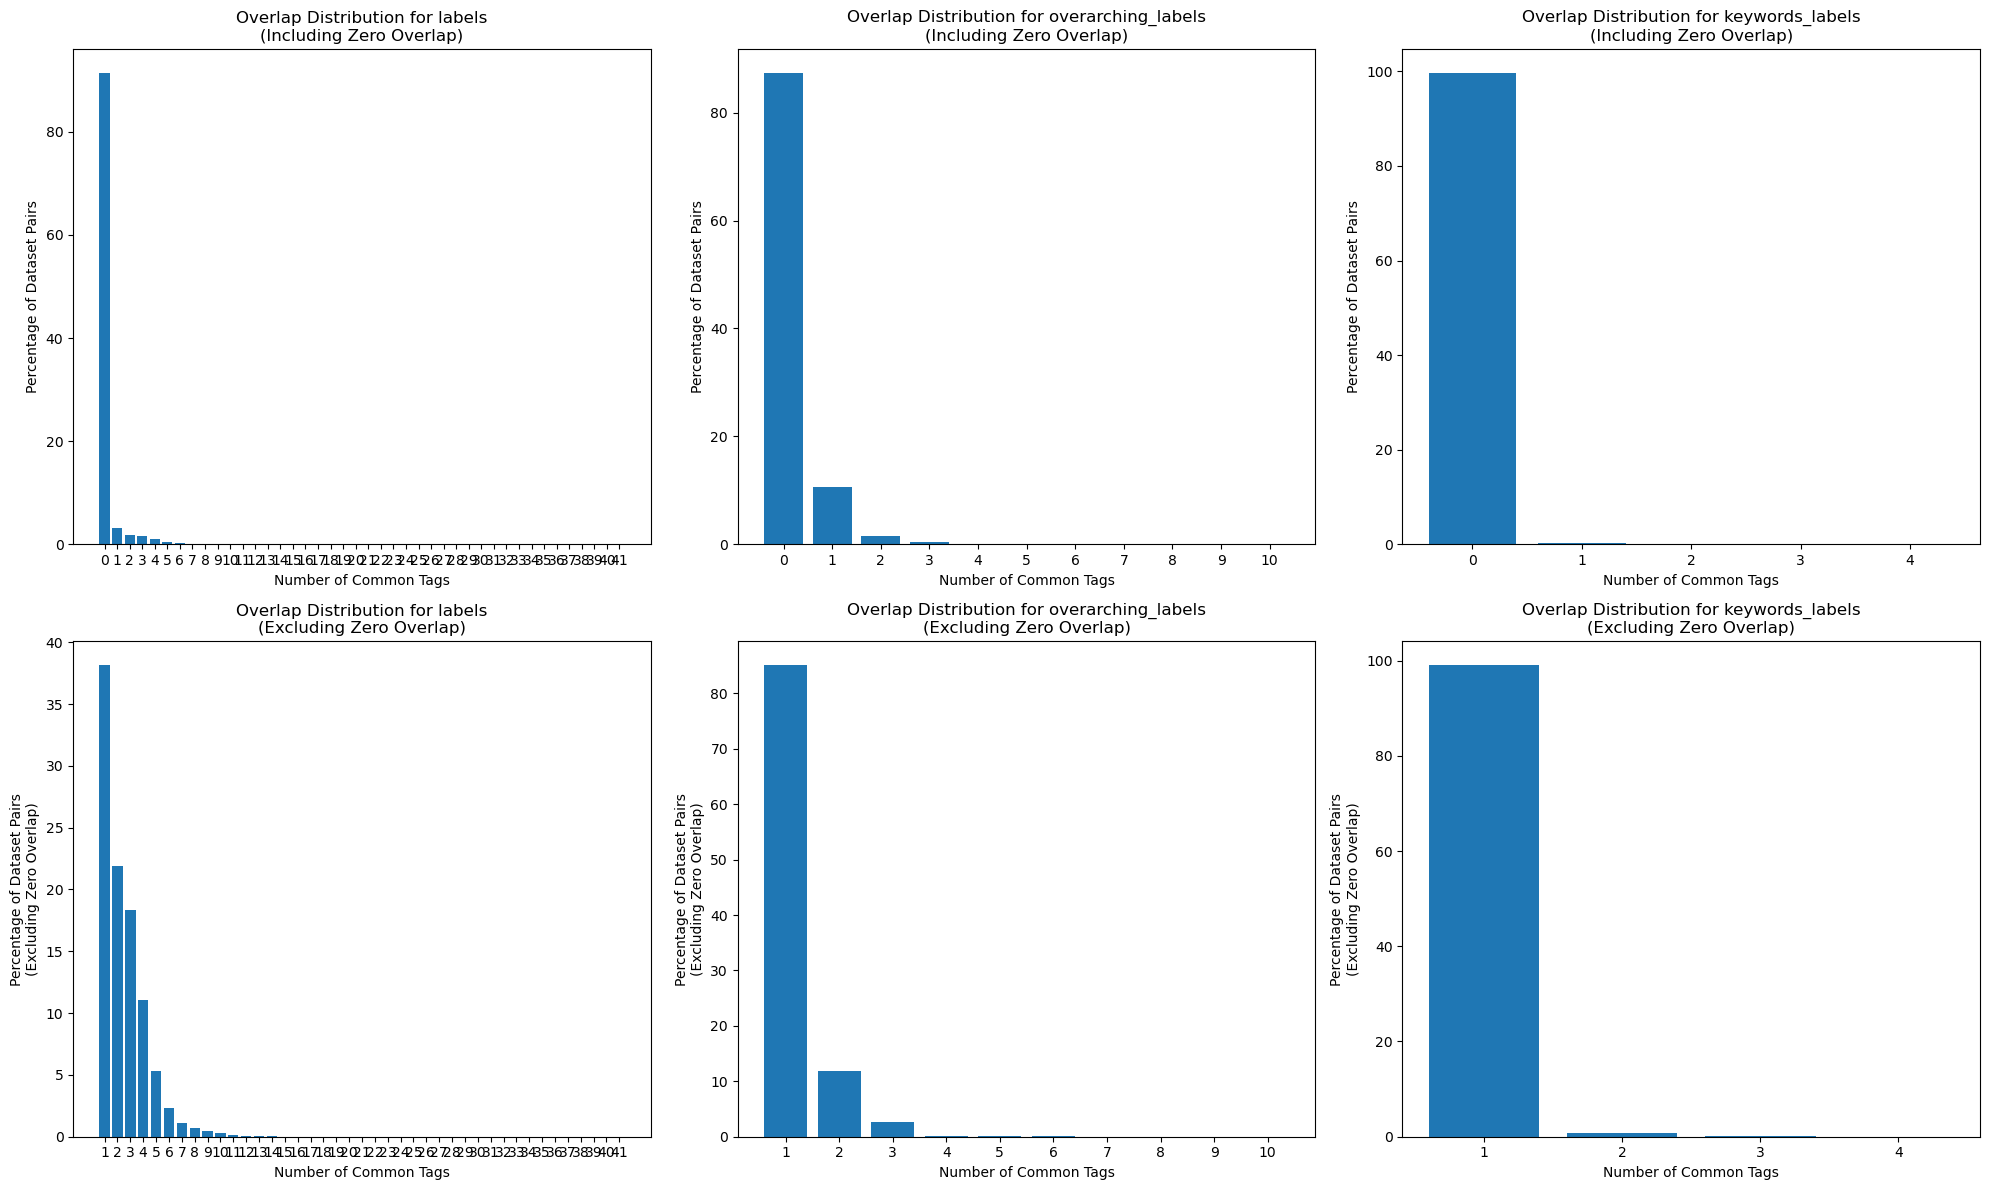

In [38]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt

def analyze_dataset_overlap(data):
    categories = ['labels', 'overarching_labels', 'keywords_labels']
    results = {}

    for cat in categories:
        dataset_labels = [set(entry.get(cat, [])) for entry in data]
        overlap_counts = defaultdict(Counter)
        datasets_with_overlap = set()
        total_overlap = 0
        total_pairs = 0

        for i in range(len(dataset_labels)):
            for j in range(i+1, len(dataset_labels)):
                overlap = len(dataset_labels[i] & dataset_labels[j])
                total_overlap += overlap
                total_pairs += 1
                if overlap > 0:
                    datasets_with_overlap.add(i)
                    datasets_with_overlap.add(j)
                overlap_counts[i][overlap] += 1
                overlap_counts[j][overlap] += 1

        # Calculate overall statistics
        total_datasets = len(dataset_labels)
        datasets_with_any_overlap = len(datasets_with_overlap)
        avg_overlap = total_overlap / total_pairs if total_pairs > 0 else 0
        
        # Calculate distribution of overlap counts
        max_overlap = max(max(counter.keys()) for counter in overlap_counts.values()) if overlap_counts else 0
        distribution = [sum(counter[i] for counter in overlap_counts.values()) for i in range(max_overlap + 1)]
        
        # Normalize distribution
        total_comparisons = sum(distribution)
        distribution_percentage = [count / total_comparisons * 100 for count in distribution]

        results[cat] = {
            'total_datasets': total_datasets,
            'datasets_with_any_overlap': datasets_with_any_overlap,
            'percentage_datasets_with_overlap': (datasets_with_any_overlap / total_datasets) * 100,
            'distribution': distribution,
            'distribution_percentage': distribution_percentage,
            'avg_overlap': avg_overlap
        }

    return results

def plot_overlap_distribution(results):
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    categories = ['labels', 'overarching_labels', 'keywords_labels']
    
    for i, cat in enumerate(categories):
        data = results[cat]
        
        # Plot including zero overlap
        axs[0, i].bar(range(len(data['distribution'])), data['distribution_percentage'])
        axs[0, i].set_title(f'Overlap Distribution for {cat}\n(Including Zero Overlap)')
        axs[0, i].set_xlabel('Number of Common Tags')
        axs[0, i].set_ylabel('Percentage of Dataset Pairs')
        axs[0, i].set_xticks(range(len(data['distribution'])))
        
        # Plot excluding zero overlap
        non_zero_distribution = data['distribution'][1:]
        non_zero_percentage = [count / sum(non_zero_distribution) * 100 for count in non_zero_distribution]
        axs[1, i].bar(range(1, len(non_zero_distribution) + 1), non_zero_percentage)
        axs[1, i].set_title(f'Overlap Distribution for {cat}\n(Excluding Zero Overlap)')
        axs[1, i].set_xlabel('Number of Common Tags')
        axs[1, i].set_ylabel('Percentage of Dataset Pairs\n(Excluding Zero Overlap)')
        axs[1, i].set_xticks(range(1, len(non_zero_distribution) + 1))

    plt.tight_layout()
    plt.show()

# Analyze and print results
overlap_results = analyze_dataset_overlap(human_evaluation)

for category, results in overlap_results.items():
    print(f"\n{category.capitalize()}:")
    print(f"Total datasets: {results['total_datasets']}")
    print(f"Datasets with any overlap: {results['datasets_with_any_overlap']} ({results['percentage_datasets_with_overlap']:.2f}%)")
    print(f"Average overlap between datasets: {results['avg_overlap']:.2f} tags")
    print("Distribution of overlaps:")
    for i, count in enumerate(results['distribution']):
        if count > 0:
            print(f"  {i} common tag(s): {count} pairs ({results['distribution_percentage'][i]:.2f}%)")

    # Print non-zero distribution
    print("Distribution of overlaps (excluding zero overlap):")
    non_zero_distribution = results['distribution'][1:]
    non_zero_total = sum(non_zero_distribution)
    for i, count in enumerate(non_zero_distribution, start=1):
        if count > 0:
            percentage = (count / non_zero_total) * 100
            print(f"  {i} common tag(s): {count} pairs ({percentage:.2f}%)")

# Plot the distributions
plot_overlap_distribution(overlap_results)